<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Udesha-/SARIMA_Wind_Speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing python packages**

In [1]:
pip install pmdarima

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm

# **Data Preprocessing**

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/August-2021%20Mannar%20Wind%20Data1.csv')
df = df.rename(columns = {'TimeStamp': 'Date & Time', 'Average  Wind Speed(m/s)': 'Wind Speed (m/s)', 'Average  Wind Dirction(deg)':'Wind Direction(deg)','Average Active Power(MW)':'Active Power(MW)'}, inplace = False)
df=df[['Date & Time','Active Power(MW)','Wind Speed (m/s)','Wind Direction(deg)']]
df

,Date & Time,Active Power(MW),Wind Speed (m/s),Wind Direction(deg)
0,8/1/2021 0:00,95.84,10.66,186.92
1,8/1/2021 0:10,96.03,10.71,188.15
2,8/1/2021 0:20,93.72,10.53,188.78
3,8/1/2021 0:30,88.84,10.20,189.80
4,8/1/2021 0:40,90.97,10.34,193.00
...,...,...,...,...
4404,8/31/2021 23:20,100.45,11.62,195.08
4405,8/31/2021 23:30,98.01,11.16,196.36
4406,8/31/2021 23:40,93.11,10.66,198.02
4407,8/31/2021 23:50,93.68,10.90,196.96


In [4]:
#df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv')
df=df[['Date & Time','Active Power(MW)']]
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format="%m/%d/%Y %H:%M")
df["Active Power(MW)"] = pd.to_numeric(df["Active Power(MW)"])
df.set_index('Date & Time',inplace=True)
df=df.tail(3000)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Active Power(MW)
Date & Time,
2021-08-11 04:10:00,63.82
2021-08-11 04:20:00,56.68
2021-08-11 04:30:00,48.38
2021-08-11 04:40:00,44.54
2021-08-11 04:50:00,42.52


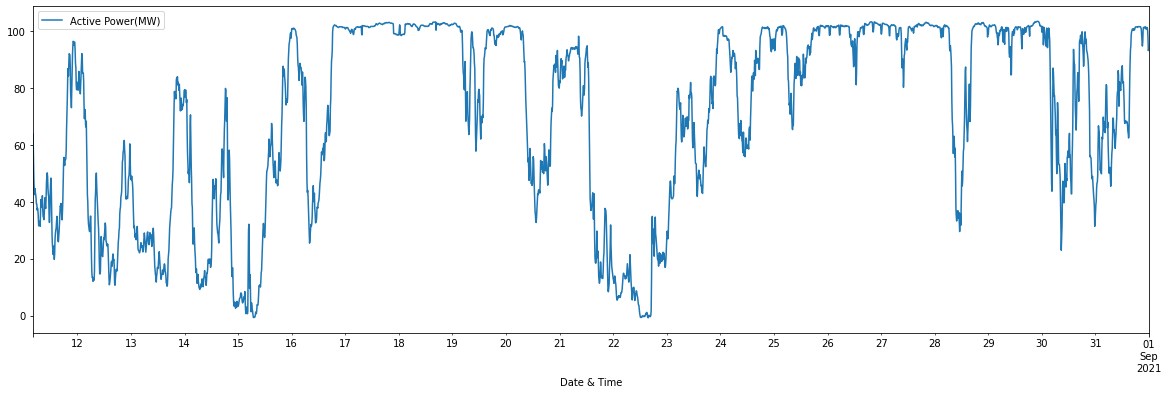

In [5]:
df.plot(figsize = (20, 6))
plt.show()

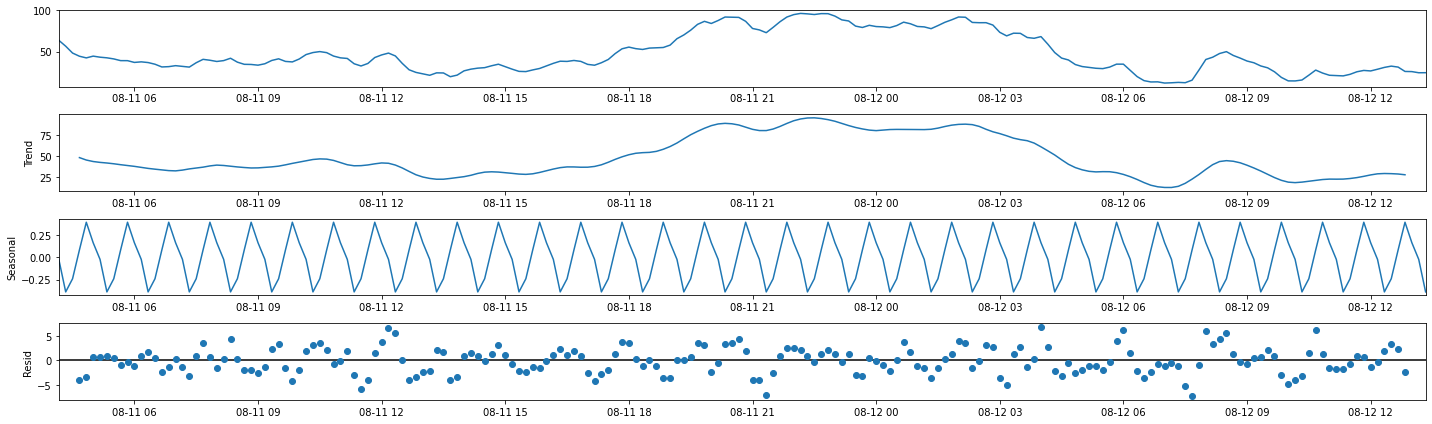

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
decomposition = sm.tsa.seasonal_decompose(df.head(200), model='additive',period=6)
fig = decomposition.plot()
plt.show()

*sesonal_lags_6*

# **Check Data Stationarity**

In [7]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):    
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [8]:
check_stationarity(df["Active Power(MW)"])

The test statistic: -3.948306
p-value: 0.001707
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


not-stationary

In [9]:
df_diff=df.diff(periods=1)
df_diff=df_diff[1:]
df_diff.head()

,Active Power(MW)
Date & Time,
2021-08-11 04:20:00,-7.14
2021-08-11 04:30:00,-8.30
2021-08-11 04:40:00,-3.84
2021-08-11 04:50:00,-2.02
2021-08-11 05:00:00,2.14


In [10]:
check_stationarity(df_diff["Active Power(MW)"])

The test statistic: -16.523098
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


now the series is trend stationary(d=1)

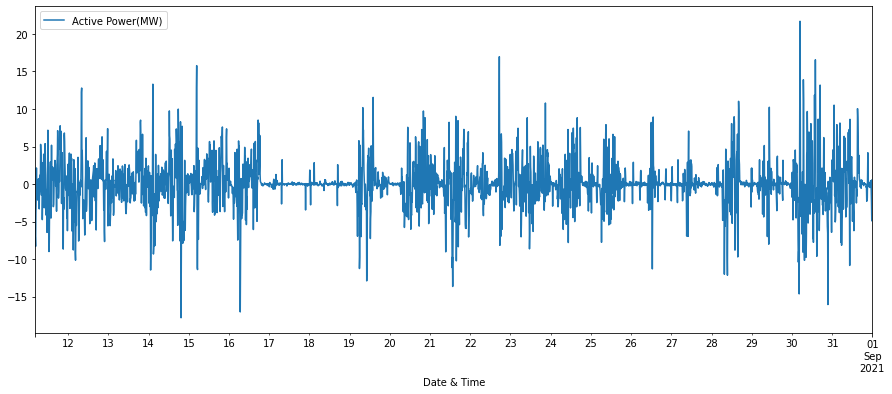

In [11]:
df_diff.plot(figsize = (15, 6))
plt.show()

In [12]:
df_sdiff=df_diff.diff(periods=6)

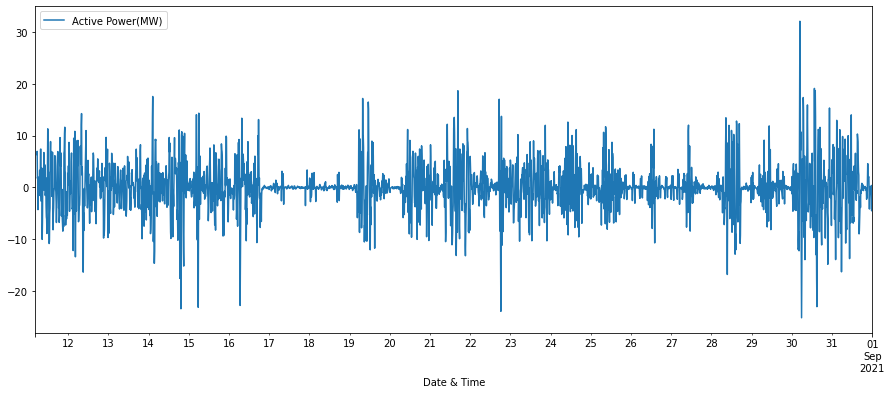

In [13]:
df_sdiff.plot(figsize = (15, 6))
plt.show()

In [14]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df["Active Power(MW)"], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14527.085, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15266.298, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14617.544, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14536.806, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15264.329, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14525.057, Time=1.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14523.091, Time=0.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14525.080, Time=0.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14523.091, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14525.075, Time=1.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14538.277, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14521.103, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14534.821, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14615.553, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0

In [15]:
# from pmdarima.arima import auto_arima
# #Autoarima gives us bet model suited for the data
# # p - number of autoregressive terms (AR)
# # q - Number of moving avergae terms (MA)
# # d - number of non-seasonal differences
# #p, d, q represent non-seasonal components
# #P, D, Q represent seasonal components
# arima_model = auto_arima(df["Active Power(MW)"], start_p = 1, d=1, start_q = 1, 
#                           max_p = 5, max_q = 5, max_d=5, m = 6, 
#                           start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
#                           seasonal = True, 
#                           trace = True, 
#                           error_action ='ignore',   
#                           suppress_warnings = True,  
#                           stepwise = True, n_fits=50)           
  
# # To print the summary 
# print(arima_model.summary() ) #Note down the Model and details.
# # Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

In [16]:
# print(arima_model.summary() ) 

In [17]:
train=df[0:2994]
test=df[2994:]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


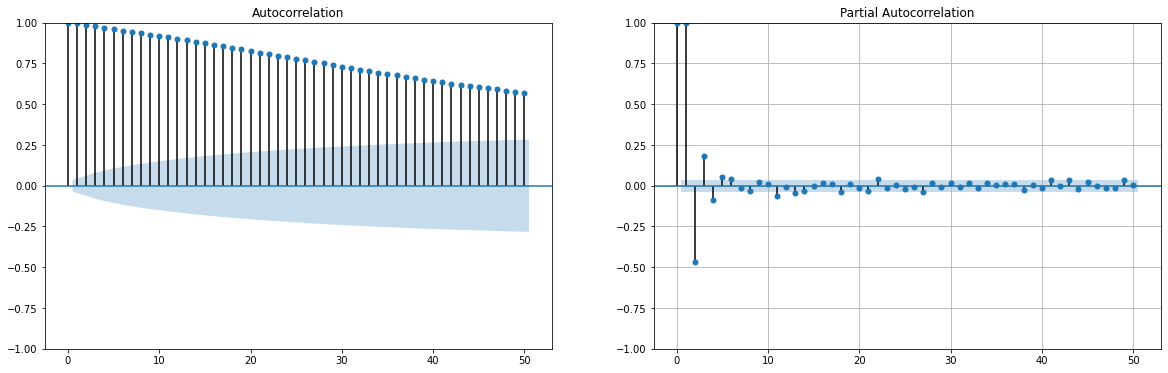

In [18]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(1,2)
fig = sm.graphics.tsa.plot_acf(train, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=50, ax=ax[1])
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


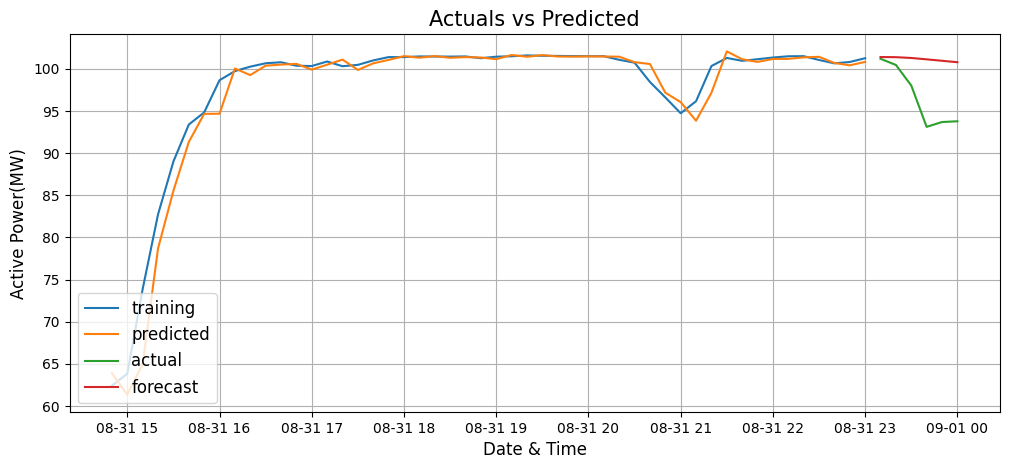

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create a SARIMAX model
model = SARIMAX(train, order=(5,0,0), seasonal_order=(5,0,0, 6))
# Fit the model
results = model.fit()
# Print the results summary
#results.summary()
pre=results.predict()
fc= results.forecast(6)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
pre_series = pd.Series(pre, index=train.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.tail(50), label='training')
plt.plot(pre.tail(50),label='predicted')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.ylabel("Active Power(MW)", fontsize=12)
plt.xlabel("Date & Time", fontsize=12)

plt.title('Actuals vs Predicted', fontsize=15)
plt.legend(loc='lower left', fontsize=12)
plt.grid()

In [36]:
from statsmodels.tsa.arima_model import ARIMA
df_model=ARIMA(train,order=(2,1,2))
df_model_fit=df_model.fit()
df_model_fit.aic

NotImplementedError: ignored

In [28]:

from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(train,pre)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred)) / actual) * 100

actual = train
pred = pre

MAPE=mape(actual, pred)

In [29]:
print('MSE = '+ str(MSE))
print('MAPE = '+ str(MAPE))

MSE = 8.783735877026539
MAPE = 33.688718942328435
